In [1]:
from ticl.models.flash_transformer import MultiheadAttention
import torch
import pandas as pd
from ticl.models.layer import TransformerEncoderLayer
# plot, for each column compute mean and std error
import matplotlib.pyplot as plt
import sys, os

os.environ['CUDA_VISIBLE_DEVICES'] = '3'
root_dir = os.path.dirname(os.getcwd())
sys.path.append(root_dir)
from benchmark import get_csv, benchmark

In [2]:
markers = ['o', 'x', 's', 'D', '^', 'v', 'p', 'h', '8', '*', 'H', 'd', 'P', 'X', '<', '>']
marker_sizes = [14,12,10,8,6,4,2]

In [3]:
embed_dim, num_heads = 32, 2

In [4]:
fa = MultiheadAttention(embed_dim, num_heads, attn_name = 'flash_attention', device = 'cuda', batch_first = True)
fla = MultiheadAttention(embed_dim, num_heads, attn_name = 'flash_linear_attention', device = 'cuda', batch_first = True)

/datadrive/fla2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/azureuser/flash-linear-attention/fla/layers/attn.py:23: UserWarning: Flash Attention is not installed. Please install it via `pip install flash-attn --no-build-isolation`
  warnings.warn("Flash Attention is not installed. Please install it via `pip install flash-attn --no-build-isolation`")


# Check the correctness 

In [5]:
batch_size, sl = 2, 256

q = torch.randn(batch_size * num_heads, sl, embed_dim, device = "cuda")
k = q
v = q

In [6]:
fao1 = fa(q, k, v, need_weights = False)[0]
fao2 = fa(q, k, v, need_weights = True)[0]
torch.allclose(fao1, fao2, atol=1e-3)

True

In [7]:
flano1 = fla(q, k, v, need_weights = False, is_causal = False)[0]
flano2 = fla(q, k, v, need_weights = True, is_causal = False)[0]
torch.allclose(flano1, flano2, atol=1e-3)

True

In [8]:
flaco1 = fla(q, k, v, need_weights = False, is_causal = True)[0]
flaco2 = fla(q, k, v, need_weights = True, is_causal = True)[0]
torch.allclose(flaco1, flaco2, atol=1e-3)

True

# Transformer Layer

In [5]:
fla_tf = TransformerEncoderLayer(embed_dim, num_heads, attn_name = 'flash_linear_attention', device = 'cuda', dropout = 0)
fa_tf = TransformerEncoderLayer(embed_dim, num_heads, attn_name = 'flash_attention', device = 'cuda')

# Benchmark

In [6]:
def get_model(model_name, **kwargs):
    if model_name == 'flash_attention':
        model = fa
    elif model_name == 'flash_linear_attention':
        model = fla
    elif model_name == 'flash_linear_tf':
        model = fla_tf
    elif model_name == 'flash_tf':
        model = fa_tf
    elif model_name == 'linear_attention':
        model = linear_attention
    elif model_name == 'linear_tf':
        model = linear_tf
    elif model_name == 'simplified_linear_attention':
        from linear_attn_forward import linear_attention as simplified_linear_attention
        model = simplified_linear_attention(default_mask = True, event_dispatcher = True, **kwargs).to('cuda')
    else:
        raise ValueError(f"model_name {model_name} not supported")
    return model

# Self-attention

In [8]:
overwrite = True

In [9]:
benchmark('flash_attention', get_model, is_causal = False, self_attn = True, overwrite = overwrite)

In [10]:
benchmark('flash_linear_attention', get_model, is_causal = False, self_attn = True, overwrite = overwrite)

In [11]:
benchmark('flash_tf', get_model, is_causal = False, self_attn = True, overwrite = overwrite, max_len_power=17)

In [12]:
benchmark('flash_linear_tf', get_model, is_causal = False, self_attn = True, overwrite = overwrite, max_len_power=19)

In [8]:
results = {}
plot_order = [
    ('flash_attention', False), 
    ('flash_linear_attention', False), 
    # ('flash_linear_attention', True),
    ('flash_tf', False),
    ('flash_linear_tf', False),
    ('linear_attention', False),
    ('linear_tf', False),
]

for mode in ['memory', 'time']:
    results[mode] = {}
    for model_name, is_causal in plot_order:
        causal_flag = "_causal" if is_causal else ""
        results[mode][f"{model_name}{causal_flag}"] = pd.read_csv(get_csv(is_causal, True, model_name, mode), index_col = 0)

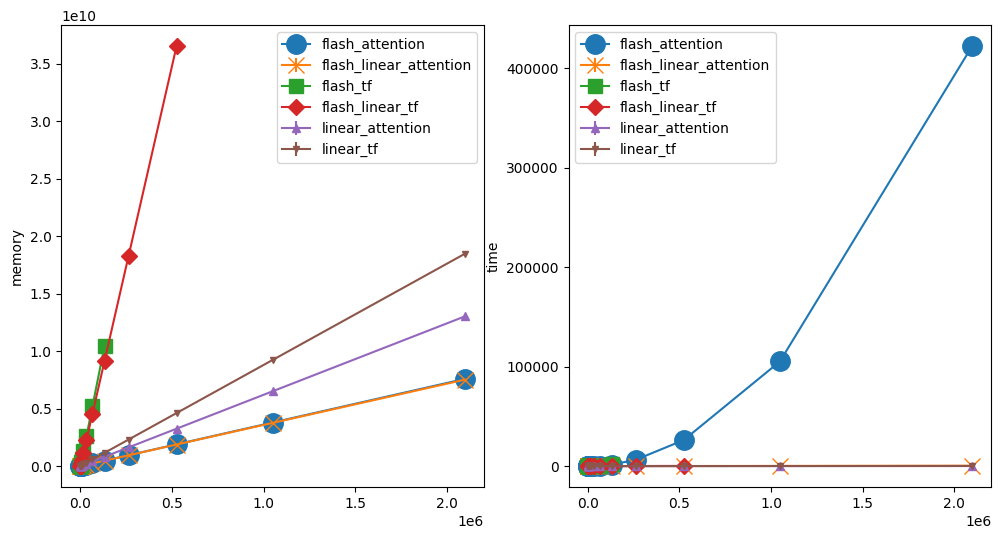

In [9]:
# create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i, mode in enumerate(['memory', 'time']):
    for j, model_attr in enumerate(plot_order):
        causal_flag = "_causal" if model_attr[1] else ""
        model_name = f"{model_attr[0]}{causal_flag}"
        df = results[mode][model_name]
        mean = df.mean()
        std = df.std()
        xticks = [int(x) for x in mean.index]
        axs[i].errorbar(xticks, mean, yerr = std, label = model_name, markersize = marker_sizes[j], marker = markers[j])
        axs[i].legend()
        axs[i].set_ylabel(mode)



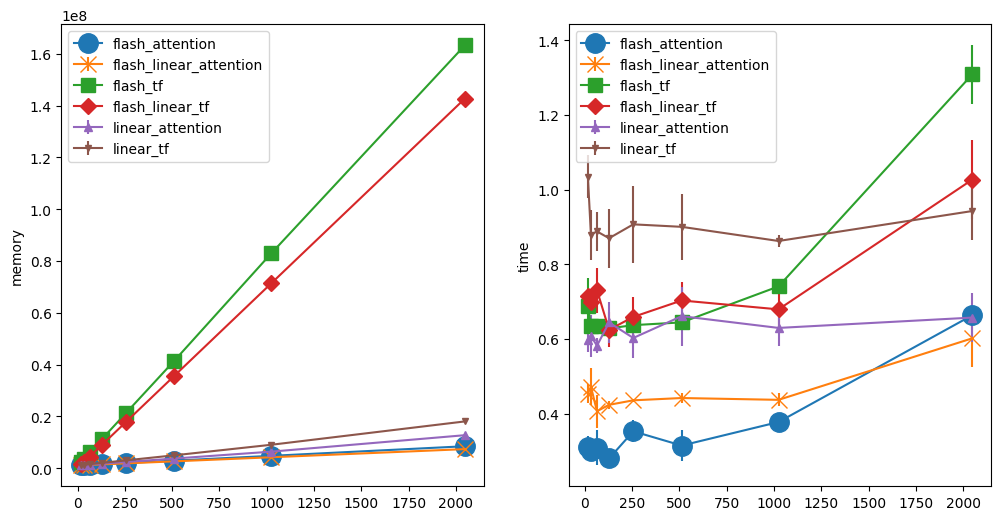

In [12]:
# check the short length region
max_length_idx = 8

# create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i, mode in enumerate(['memory', 'time']):
    for j, model_attr in enumerate(plot_order):
        causal_flag = "_causal" if model_attr[1] else ""
        model_name = f"{model_attr[0]}{causal_flag}"
        df = results[mode][model_name]
        mean = df.mean()
        std = df.std()
        xticks = [int(x) for x in mean.index][:max_length_idx]
        axs[i].errorbar(xticks, mean[:max_length_idx], yerr = std[:max_length_idx], label = model_name, markersize = marker_sizes[j], marker = markers[j])
        axs[i].legend()
        axs[i].set_ylabel(mode)


# Cross Attention

In [16]:
benchmark('flash_attention', is_causal = False, self_attn = False, overwrite=True)

In [17]:
benchmark('flash_linear_attention', is_causal = False, self_attn = False, overwrite=True)

In [18]:
benchmark('flash_tf', is_causal = False, self_attn = False, overwrite=True)

In [19]:
benchmark('flash_linear_tf', is_causal = False, self_attn = False, overwrite=True)

# Plot

In [23]:
results = {}

for mode in ['memory', 'time']:
    results[mode] = {}
    for model_name, is_causal in (
        ('flash_attention', False), 
        ('flash_linear_attention', False), 
        ('flash_tf', False),
        ('flash_linear_tf', False)
    ):
        causal_flag = "_causal" if is_causal else ""
        results[mode][f"{model_name}{causal_flag}"] = pd.read_csv(get_csv(is_causal, False, model_name, mode), index_col = 0)

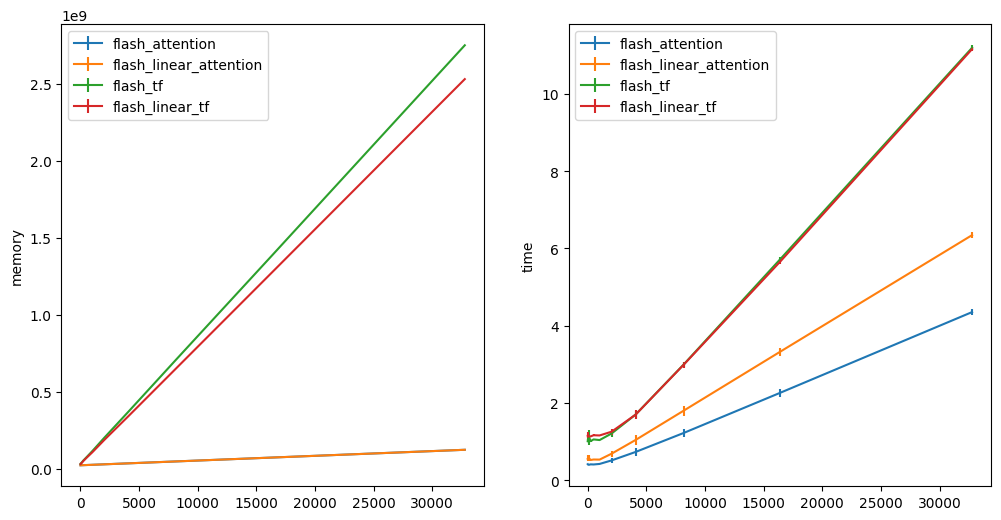

In [24]:
# create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i, mode in enumerate(['memory', 'time']):
    for model_name in results[mode]:
        df = results[mode][model_name]
        mean = df.mean()
        std = df.std()
        xticks = [int(x) for x in mean.index]
        axs[i].errorbar(xticks, mean, yerr = std, label = model_name)
        axs[i].legend()
        axs[i].set_ylabel(mode)



In [5]:
a = {(x+y):(x*y) for x in range(10) for y in range(10)}

In [6]:
a

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 9,
 11: 18,
 12: 27,
 13: 36,
 14: 45,
 15: 54,
 16: 63,
 17: 72,
 18: 81}